# Clustering Top US Colleges Based on Average Tuition and Nearby Attractions

## Table of Contents
1. Introduction
2. Data Sources
3. Data Retrieval
4. Data Processing
5. Exploratory Analysis
6. Cluster Modelling
7. Cluster Analysis & Results
8. Discussion

## Introduction

In this project, we will explore several colleges around the US and group them based on tuition and local points of interest. We will first extract names of colleges and tuition data from Business Insider (discussed further later), then utilize the Foursquare API to search for nearby veneues, and finally aggregate the data and identify similar groups of colleges. 

These findings, combined with other sources, can be useful for incoming college students conflicted on their deicision. 

## Data Sources

We will extract names and average tuitions of the top 50 US colleges from [Business Insider](https://www.businessinsider.com/best-colleges-in-america-ranked-2018-9). After, we will use Geopy to obtain location coordinates. The Foursquare API will then provide us with data for [nearby venues](https://developer.foursquare.com/docs/api/endpoints) and their categories, which we will use for the clustering analysis. 

Below is a screenshot of sample categories provided by the Foursquare API.
![Screen%20Shot%202019-08-03%20at%202.55.51%20PM.png](attachment:Screen%20Shot%202019-08-03%20at%202.55.51%20PM.png 'f')
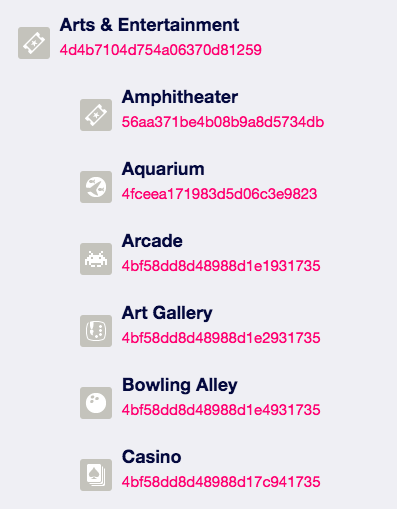

## Data Retrieval

In [1]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes
!pip3 install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!pip3 install folium
import folium # map rendering library

# libraries for webscraping 
from bs4 import BeautifulSoup
import requests

# used for caching variables so computationally-expensive cells don't need to be rerun 
!pip3 install git+https://github.com/rossant/ipycache.git
%load_ext ipycache

print('Libraries imported.')

  Cloning https://github.com/rossant/ipycache.git to /private/var/folders/nm/pbfgt5z52f1dfvdffvb2fdjc0000gn/T/pip-req-build-uqzmtz2q
  Running command git clone -q https://github.com/rossant/ipycache.git /private/var/folders/nm/pbfgt5z52f1dfvdffvb2fdjc0000gn/T/pip-req-build-uqzmtz2q
Libraries imported.


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated since IPython 4.0. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipycache.py:17: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils.traitlets import Unicode


In [2]:
# create soup obj.
url = requests.get('https://www.businessinsider.com/best-colleges-in-america-ranked-2018-9').text
soup = BeautifulSoup(url, 'lxml')

We will now create a Data Frame aggregating colleges and their respective average tuitions.

In [3]:
# extract all colleges from HTML script
colleges = soup.find('div', {'class':'slide-wrapper'}).findAll('div', {'class':'slide'})
# append data to Data Frame
df = pd.DataFrame(columns=['College', 'Average Tuition'])
for college in colleges:
    df = df.append({'College':college.find('h2').text[college.find('h2').text.find('.') + 2:], 'Average Tuition':college.find('div').findAll('div')[2].findAll('p')[5].text[20:]}, ignore_index=True)
df.head()

College Average Tuition
0                                 Bryn Mawr College         31,900 
1                           Lehigh University (tie)         27,478 
2  University of Illinois at Urbana-Champaign (tie)         16,683 
3                               University of Miami         37,424 
4                               Wesleyan University         20,490

## Data Processing

In [4]:
# re-index Data Frame and clean
df = df[::-1]
df = df.reset_index(drop=True)
df['Average Tuition'] = df['Average Tuition'].str.replace(',', '')
df['Average Tuition'] = df['Average Tuition'].astype(int)
df['College'].replace('\\(tie\\)', '', regex=True, inplace=True)
df['College'].loc[24] = 'University of California Los Angeles' # geolocator crashes when searching unless comma is removed
df.shape

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


(50, 2)

We will use geolocator from Geopy to return location coordinates for each college and append to Data Frame. Geolocator crashes when geocoding more than 20 colleges, so the colleges are divided into 3 groups and then geocoded. 

In [5]:
%%cache geocode_df.pkl df_1, df_2, df_3
df_1 = df[:21]
# append coordinates to dataframe
geolocator = Nominatim(user_agent="explorer")
df_1['Coordinates'] = df_1['College'].apply(geolocator.geocode)
df_1['Coordinates'] = df_1['Coordinates'].apply(lambda x: (x.latitude, x.longitude))

df_2 = df[21:41]
# append coordinates to dataframe
df_2['Coordinates'] = df_2['College'].apply(geolocator.geocode)
df_2['Coordinates'] = df_2['Coordinates'].apply(lambda x: (x.latitude, x.longitude))

df_3 = df[41:]
# append coordinates to dataframe
df_3['Coordinates'] = df_3['College'].apply(geolocator.geocode)
df_3['Coordinates'] = df_3['Coordinates'].apply(lambda x: (x.latitude, x.longitude))

[Skipped the cell's code and loaded variables df_1, df_2, df_3 from file '/Users/Aman/Documents/Jupyter Notebooks/Coursera Capstone/geocode_df.pkl'.]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

This Data Frame contains all relevant data needed before searching for venues near each college.

In [6]:
df = pd.concat([df_1, df_2, df_3])
df['College'].loc[24] = 'University of California, Los Angeles' # place comma back, as no further need for geolocator
df.head()

College  Average Tuition  \
0                     Harvard University            16205   
1  Massachusetts Institute of Technology            21576   
2                        Yale University            18319   
3                    Columbia University            22973   
4     California Institute of Technology            26839   

                        Coordinates  
0  (42.36782045, -71.1266665287448)  
1   (42.3583961, -71.0956778766393)  
2  (41.25713055, -72.9896696015223)  
3   (40.8071772, -73.9625279772072)  
4  (34.13710185, -118.125274866116)

Two functions are defined to make calls to the Foursquare API. The first simply returns a URL containing authorization credentials and location boundaries for the college we would like to search near. This function will be called for each college to retrive its unique venues. The second function returns a Data Frame containing all nearby venues and respective info.

In [7]:
# credentials to make API calls
CLIENT_ID = 'CNRPB1BC1FIXUXXKPR10A2AA1GAC3ZR5CELZRV5BDPO1TXKG'
CLIENT_SECRET = 'NWWUGVIAZ0UCDYSDJFCXLABMKSXS3QPDBHINZUE1YKHEA2MU' 
VERSION = '20181102'

# function to format URL
def format_url(lat, long, radius=2000, limit=100):
    return 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, 
        lat, long, VERSION, radius, limit)

# function to get venues near a particular college
def get_venues(url):
    results = requests.get(url).json()
    venues = results['response']['groups'][0]['items']
    return json_normalize(venues)

We will test these functions for Harvard University to ensure no errors. 

In [8]:
# test for Harvard University
url = format_url(df['Coordinates'].loc[1][0], df['Coordinates'].loc[1][1])
nearby_venues = get_venues(url)
nearby_venues.head()

referralId  reasons.count  \
0  e-0-53fce514498e8a98848de4d7-0              0   
1  e-0-4c24a25eb7b8a59364b93ce8-1              0   
2  e-0-54502009498e59da3cbd35c0-2              0   
3  e-0-4dd177b8d164679b8d479c91-3              0   
4  e-0-42fbe680f964a520e7261fe3-4              0   

                                       reasons.items  \
0  [{'summary': 'This spot is popular', 'type': '...   
1  [{'summary': 'This spot is popular', 'type': '...   
2  [{'summary': 'This spot is popular', 'type': '...   
3  [{'summary': 'This spot is popular', 'type': '...   
4  [{'summary': 'This spot is popular', 'type': '...   

                   venue.id                         venue.name  \
0  53fce514498e8a98848de4d7  Zesiger Sports And Fitness Center   
1  4c24a25eb7b8a59364b93ce8                Flour Bakery + Cafe   
2  54502009498e59da3cbd35c0                      Darwin's Ltd.   
3  4dd177b8d164679b8d479c91                          Area Four   
4  42fbe680f964a520e7261fe3                        Cuchi Cuchi   

   venue.location.lat  venue.location.lng  \
0           42.358802          -71.095888   
1           42.361123          -71.096521   
2           42.362402          -71.098514   
3           42.363096          -71.092185   
4           42.363321          -71.097095   

                       venue.location.labeledLatLngs  venue.location.distance  \
0  [{'label': 'display', 'lat': 42.35880219956315...                       48   
1  [{'label': 'display', 'lat': 42.36112299047327...                      311   
2  [{'label': 'display', 'lat': 42.36240224578378...                      503   
3  [{'label': 'display', 'lat': 42.36309634853813...                      596   
4  [{'label': 'display', 'lat': 42.36332069091929...                      560   

  venue.location.cc  ... venue.venuePage.id venue.delivery.id  \
0                US  ...                NaN               NaN   
1                US  ...                NaN               NaN   
2                US  ...                NaN               NaN   
3                US  ...                NaN               NaN   
4                US  ...                NaN               NaN   

  venue.delivery.url venue.delivery.provider.name  \
0                NaN                          NaN   
1                NaN                          NaN   
2                NaN                          NaN   
3                NaN                          NaN   
4                NaN                          NaN   

  venue.delivery.provider.icon.prefix  venue.delivery.provider.icon.sizes  \
0                                 NaN                                 NaN   
1                                 NaN                                 NaN   
2                                 NaN                                 NaN   
3                                 NaN                                 NaN   
4                                 NaN                                 NaN   

  venue.delivery.provider.icon.name venue.events.count venue.events.summary  \
0                               NaN                NaN                  NaN   
1                               NaN                NaN                  NaN   
2                               NaN                NaN                  NaN   
3                               NaN                NaN                  NaN   
4                               NaN                NaN                  NaN   

  venue.location.neighborhood  
0                         NaN  
1                         NaN  
2                         NaN  
3                         NaN  
4                         NaN  

[5 rows x 30 columns]

Foursquare returns venues' __broad__ and __specific__ categories. We will append both categories to the Data Frame, as we don't know which will be more useful later on.

In [9]:
# function to extract general category name
def extract_broad_category(row):
    broad_category = row['venue.categories'][0]['icon']['prefix'].split('/')[5]
    return broad_category

# function to extract specific category name
def extract_specific_category(row):
    specific_category = row['venue.categories'][0]['name']
    return specific_category

In [10]:
# modify Data Frame to contain venue name, broad category, and specific category
nearby_venues['Broad Category'] = nearby_venues.apply(extract_broad_category, axis=1)
nearby_venues['Specific Category'] = nearby_venues.apply(extract_specific_category, axis=1)
nearby_venues = nearby_venues[['venue.name', 'Broad Category', 'Specific Category']]
nearby_venues.rename(columns={'venue.name':'Venue Name'}, inplace=True)
nearby_venues.head()

Venue Name Broad Category     Specific Category
0  Zesiger Sports And Fitness Center       building  Gym / Fitness Center
1                Flour Bakery + Cafe           food                Bakery
2                      Darwin's Ltd.           food        Sandwich Place
3                          Area Four           food           Pizza Place
4                        Cuchi Cuchi      nightlife                Lounge

The function below iterates through the Data Frame containing college names, average tuition, and coordinates (defined above) and returns a new one with nearby venues for each college and their broad and specific categories (provided by Foursquare API).

In [11]:
# function to construct Data Frame with venue info for each college
def get_all_categories(colleges, tuitions, lats, longs):
    result_df = pd.DataFrame(columns=['College', 'Average Tuition', 'College Coordinates', 'Venue', 'Venue Coordinates', 'Broad Category', 'Specific Category'])
    for college, tuition, lat, long in zip(colleges, tuitions, lats, longs):
        url = format_url(lat, long)
        nearby_venues = requests.get(url).json()['response']['groups'][0]['items']
        venue_name = [venue['venue']['name'] for venue in nearby_venues]
        broad_categories = [venue['venue']['categories'][0]['icon']['prefix'].split('/')[5] for venue in nearby_venues]
        specific_categories = [venue['venue']['categories'][0]['name'] for venue in nearby_venues]
        venue_coords = [(venue['venue']['location']['lat'], venue['venue']['location']['lng']) for venue in nearby_venues]
        df = pd.DataFrame({'College':[college for i in range(len(venue_name))], 'Average Tuition':[tuition for i in range(len(venue_name))], 'College Coordinates':[(lat, long) for i in range(len(venue_name))], 'Venue':venue_name, 'Venue Coordinates':venue_coords, 'Broad Category':broad_categories, 'Specific Category':specific_categories})
        result_df = pd.concat([result_df, df], ignore_index=True)
    return result_df

Calling the above function is computationally expensive, so we will cache the Data Frame to pickle the variable. 

In [12]:
%%cache venues_df.pkl df_venues
df_venues = get_all_categories(df['College'], df['Average Tuition'], [coord[0] for coord in df['Coordinates']], [coord[1] for coord in df['Coordinates']])

[Skipped the cell's code and loaded variables df_venues from file '/Users/Aman/Documents/Jupyter Notebooks/Coursera Capstone/venues_df.pkl'.]


This Data Frame contains all colleges, venues nearby, and venue info.

In [93]:
# display colleges and nearby venues/categories
df_venues

College Average Tuition               College Coordinates  \
0     Harvard University           16205  (42.36782045, -71.1266665287448)   
1     Harvard University           16205  (42.36782045, -71.1266665287448)   
2     Harvard University           16205  (42.36782045, -71.1266665287448)   
3     Harvard University           16205  (42.36782045, -71.1266665287448)   
4     Harvard University           16205  (42.36782045, -71.1266665287448)   
...                  ...             ...                               ...   
4382   Bryn Mawr College           31900  (40.02813555, -75.3159205851816)   
4383   Bryn Mawr College           31900  (40.02813555, -75.3159205851816)   
4384   Bryn Mawr College           31900  (40.02813555, -75.3159205851816)   
4385   Bryn Mawr College           31900  (40.02813555, -75.3159205851816)   
4386   Bryn Mawr College           31900  (40.02813555, -75.3159205851816)   

                              Venue                         Venue Coordinates  \
0                   Harvard Stadium                 (42.366997, -71.12680128)   
1                      Trader Joe's    (42.3633439875157, -71.12994385534071)   
2     John F. Kennedy Memorial Park   (42.37080162572463, -71.12280545734018)   
3               Flour Bakery + Cafe    (42.3731171074856, -71.12234866100246)   
4                  Our Fathers Deli   (42.36352042227399, -71.12945843588452)   
...                             ...                                       ...   
4382        Polo field in Bryn Mawr   (40.01733041826688, -75.31504512715563)   
4383                Platoon Fitness  (40.017533359961405, -75.31137643028316)   
4384                  Preston field   (40.01432579787122, -75.31240853078508)   
4385            Harriton Auditorium   (40.04232556521757, -75.31487429074998)   
4386                   Harriton Gym  (40.042834780895525, -75.31712362152508)   

            Broad Category   Specific Category  
0     Arts & Entertainment     College Stadium  
1                    Shops       Grocery Store  
2         Parks & Outdoors                Park  
3                     Food              Bakery  
4                Nightlife                 Bar  
...                    ...                 ...  
4382                 Shops  Athletics & Sports  
4383              Building                 Gym  
4384      Parks & Outdoors                Park  
4385  Arts & Entertainment             Theater  
4386      Parks & Outdoors    Basketball Court  

[4387 rows x 7 columns]

In [14]:
# clean Data Frame
df_venues['Broad Category'] = df_venues['Broad Category'].str.replace('_', ' & ')
df_venues['Broad Category'] = df_venues['Broad Category'].str.title()
df_venues.head()

College Average Tuition               College Coordinates  \
0  Harvard University           16205  (42.36782045, -71.1266665287448)   
1  Harvard University           16205  (42.36782045, -71.1266665287448)   
2  Harvard University           16205  (42.36782045, -71.1266665287448)   
3  Harvard University           16205  (42.36782045, -71.1266665287448)   
4  Harvard University           16205  (42.36782045, -71.1266665287448)   

                           Venue                        Venue Coordinates  \
0                Harvard Stadium                (42.366997, -71.12680128)   
1                   Trader Joe's   (42.3633439875157, -71.12994385534071)   
2  John F. Kennedy Memorial Park  (42.37080162572463, -71.12280545734018)   
3            Flour Bakery + Cafe   (42.3731171074856, -71.12234866100246)   
4               Our Fathers Deli  (42.36352042227399, -71.12945843588452)   

         Broad Category Specific Category  
0  Arts & Entertainment   College Stadium  
1                 Shops     Grocery Store  
2      Parks & Outdoors              Park  
3                  Food            Bakery  
4             Nightlife               Bar

## Exploratory Analysis

Foursquare only provides 4 venues near Carleton College, so given the lack of data, we may remove it later on to prevent skewing our cluster models. 

In [15]:
# construct Data Frame to display # of venue provided by Foursquare API
venues_in_college = df_venues[['College', 'Venue']].groupby('College').count()
venues_in_college.rename(columns={'Venue': '# of Venues'}, inplace=True)
venues_in_college

# of Venues
College                                                  
Amherst College                                        78
Boston University                                     100
Bowdoin College                                        47
Brown University                                      100
Bryn Mawr College                                      82
California Institute of Technology                    100
Carleton College                                        4
Carnegie Mellon University                             89
Case Western Reserve University                       100
Claremont McKenna College                             100
Columbia University                                   100
Cornell University                                     67
Dartmouth College                                      56
Duke University                                        67
Emory University                                       97
Georgetown University                                 100
Harvard University                                    100
Haverford College                                     100
Johns Hopkins University                              100
Lehigh University                                     100
Massachusetts Institute of Technology                 100
Middlebury College                                     48
New York University                                   100
Northwestern University                               100
Pomona College                                        100
Princeton University                                  100
Purdue University West Lafayette                      100
Rice University                                       100
Smith College                                          84
Stanford University                                   100
Swarthmore College                                     80
Tufts University                                      100
University of California, Berkeley                    100
University of California, Davis                        16
University of California, Los Angeles                 100
University of California, San Diego                   100
University of Chicago                                 100
University of Illinois at Urbana-Champaign            100
University of Miami                                   100
University of Michigan — Ann Arbor                     79
University of North Carolina at Chapel Hill           100
University of Notre Dame                               97
University of Pennsylvania                            100
University of Southern California                     100
Vanderbilt University                                 100
Washington University in St Louis                     100
Wellesley College                                      70
Wesleyan University                                    92
Williams College                                       41
Yale University                                        93

In [16]:
# display descriptive statistics on # of venues
venues_in_college.describe()

# of Venues
count    50.000000
mean     87.740000
std      22.552261
min       4.000000
25%      82.500000
50%     100.000000
75%     100.000000
max     100.000000

We can see all types of __broad__ and __specific__ venue categories present across colleges.

In [17]:
# display unique categories
print('Unique Broad Categories (%s): %s' % (len(df_venues['Broad Category'].unique()), str(list(df_venues['Broad Category'].unique()))))
print('Unique Specific Categories (%s): %s' % (len(df_venues['Specific Category'].unique()), str(list(df_venues['Specific Category'].unique()))))

Unique Broad Categories (8): ['Arts & Entertainment', 'Shops', 'Parks & Outdoors', 'Food', 'Nightlife', 'Travel', 'Building', 'Education']
Unique Specific Categories (361): ['College Stadium', 'Grocery Store', 'Park', 'Bakery', 'Bar', 'College Hockey Rink', 'Arepa Restaurant', 'Pizza Place', 'Spa', 'Indie Movie Theater', 'Mexican Restaurant', 'Hotel', 'New American Restaurant', 'Coffee Shop', 'Diner', 'Plaza', 'Tattoo Parlor', 'Salad Place', 'Record Shop', 'Theater', 'Bookstore', 'Trail', 'Rock Club', 'Café', 'Seafood Restaurant', 'Gastropub', 'American Restaurant', 'Gift Shop', 'Burger Joint', 'Clothing Store', 'Jazz Club', 'Vegetarian / Vegan Restaurant', 'Gourmet Shop', "Women's Store", 'Indian Restaurant', 'Italian Restaurant', 'Cosmetics Shop', 'Music Venue', 'Gym', 'Ice Cream Shop', 'Greek Restaurant', 'Brewery', 'Baseball Field', 'Sushi Restaurant', 'Japanese Restaurant', 'Ramen Restaurant', 'Hotpot Restaurant', 'Garden', 'Smoke Shop', 'Art Museum', 'Nightclub', 'Asian Restauran

In [18]:
%matplotlib inline

# import plotting library for charts
import matplotlib
import matplotlib.pyplot as plt

In [19]:
# function for plotting bar graph
def plot_bar(labels, freq, xlabel, ylabel, title):
    plt.figure(figsize=(14,3))
    plt.bar(np.arange(len(labels)), freq)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(np.arange(len(labels)), labels, rotation=90)
    plt.title(title)
    plt.show()

Analyzing the bar chart, descriptive statistics, and boxplot, there appear to be no outliers on tuition data. All data is also within 3 standard deviations of the mean.

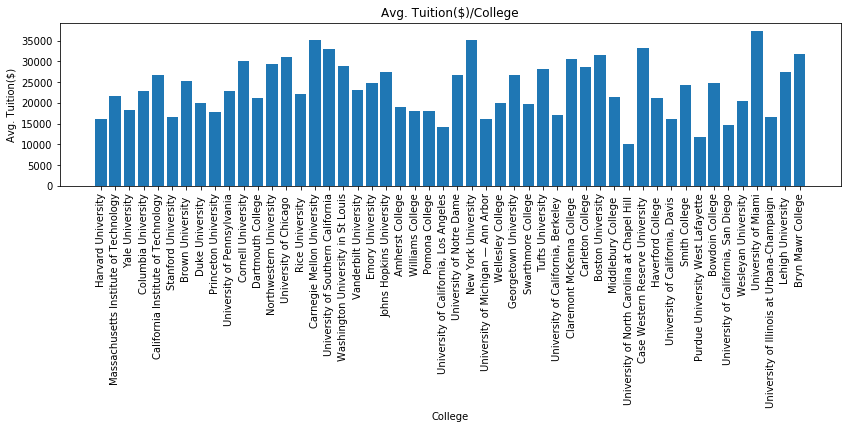

In [20]:
plot_bar(df['College'], df['Average Tuition'], 'College', 'Avg. Tuition($)', 'Avg. Tuition($)/College')

In [21]:
# display descriptive statistics on tutition data for colleges
df.describe()

Average Tuition
count        50.000000
mean      23511.260000
std        6542.076347
min       10077.000000
25%       18205.000000
50%       22958.500000
75%       28459.250000
max       37424.000000

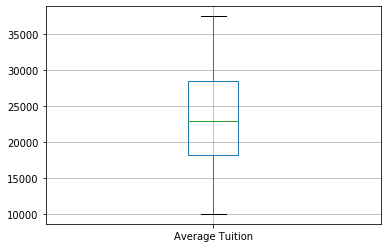

In [22]:
df[['Average Tuition']].boxplot()

In [96]:
# function to display freq. of venue category for each college
def display_freq_venue_cat(category_type, figsize=(25, 35), mode='graph', filter=None, df_venues=df_venues): # mode parameter takes graph or df (dataframe) for displaying purposes; filter parameter is to display venue category frequencies by a broad category filter 
    if category_type == 'Specific' and filter != 'None':
        df_venues = df_venues[df_venues['Broad Category'] == filter]
    if mode == 'graph':
        fig, axs = plt.subplots(10, 5, figsize=figsize)
        college = 0
        for i in range(10):
            for j in range(5):
                axs[i, j].pie(df_venues.loc[df_venues['College'] == df['College'].iloc[college]][category_type + ' Category'].value_counts(), labels=df_venues.loc[df_venues['College'] == df['College'].iloc[college]][category_type + ' Category'].value_counts().index, autopct='%.1f')
                axs[i, j].set_title(df['College'].iloc[college])
                college += 1
        plt.suptitle('Freq. of Venue Categories({}) in Each College'.format(category_type), size=18)
        plt.tight_layout()
        fig.subplots_adjust(top=0.95)
    elif mode == 'df':
        df_freq_data = []
        for college in df['College']:
            df_freq_data.append(df_venues.loc[df_venues['College'] == college][category_type + ' Category'].value_counts().to_frame().rename(columns={category_type + ' Category':'Count'}))
        return df_freq_data

The pie charts below show the distribution of __broad__ venue categories for each college. We see that Food is the dominant venue category across every college, except Carleton College and Swarthmore College. 

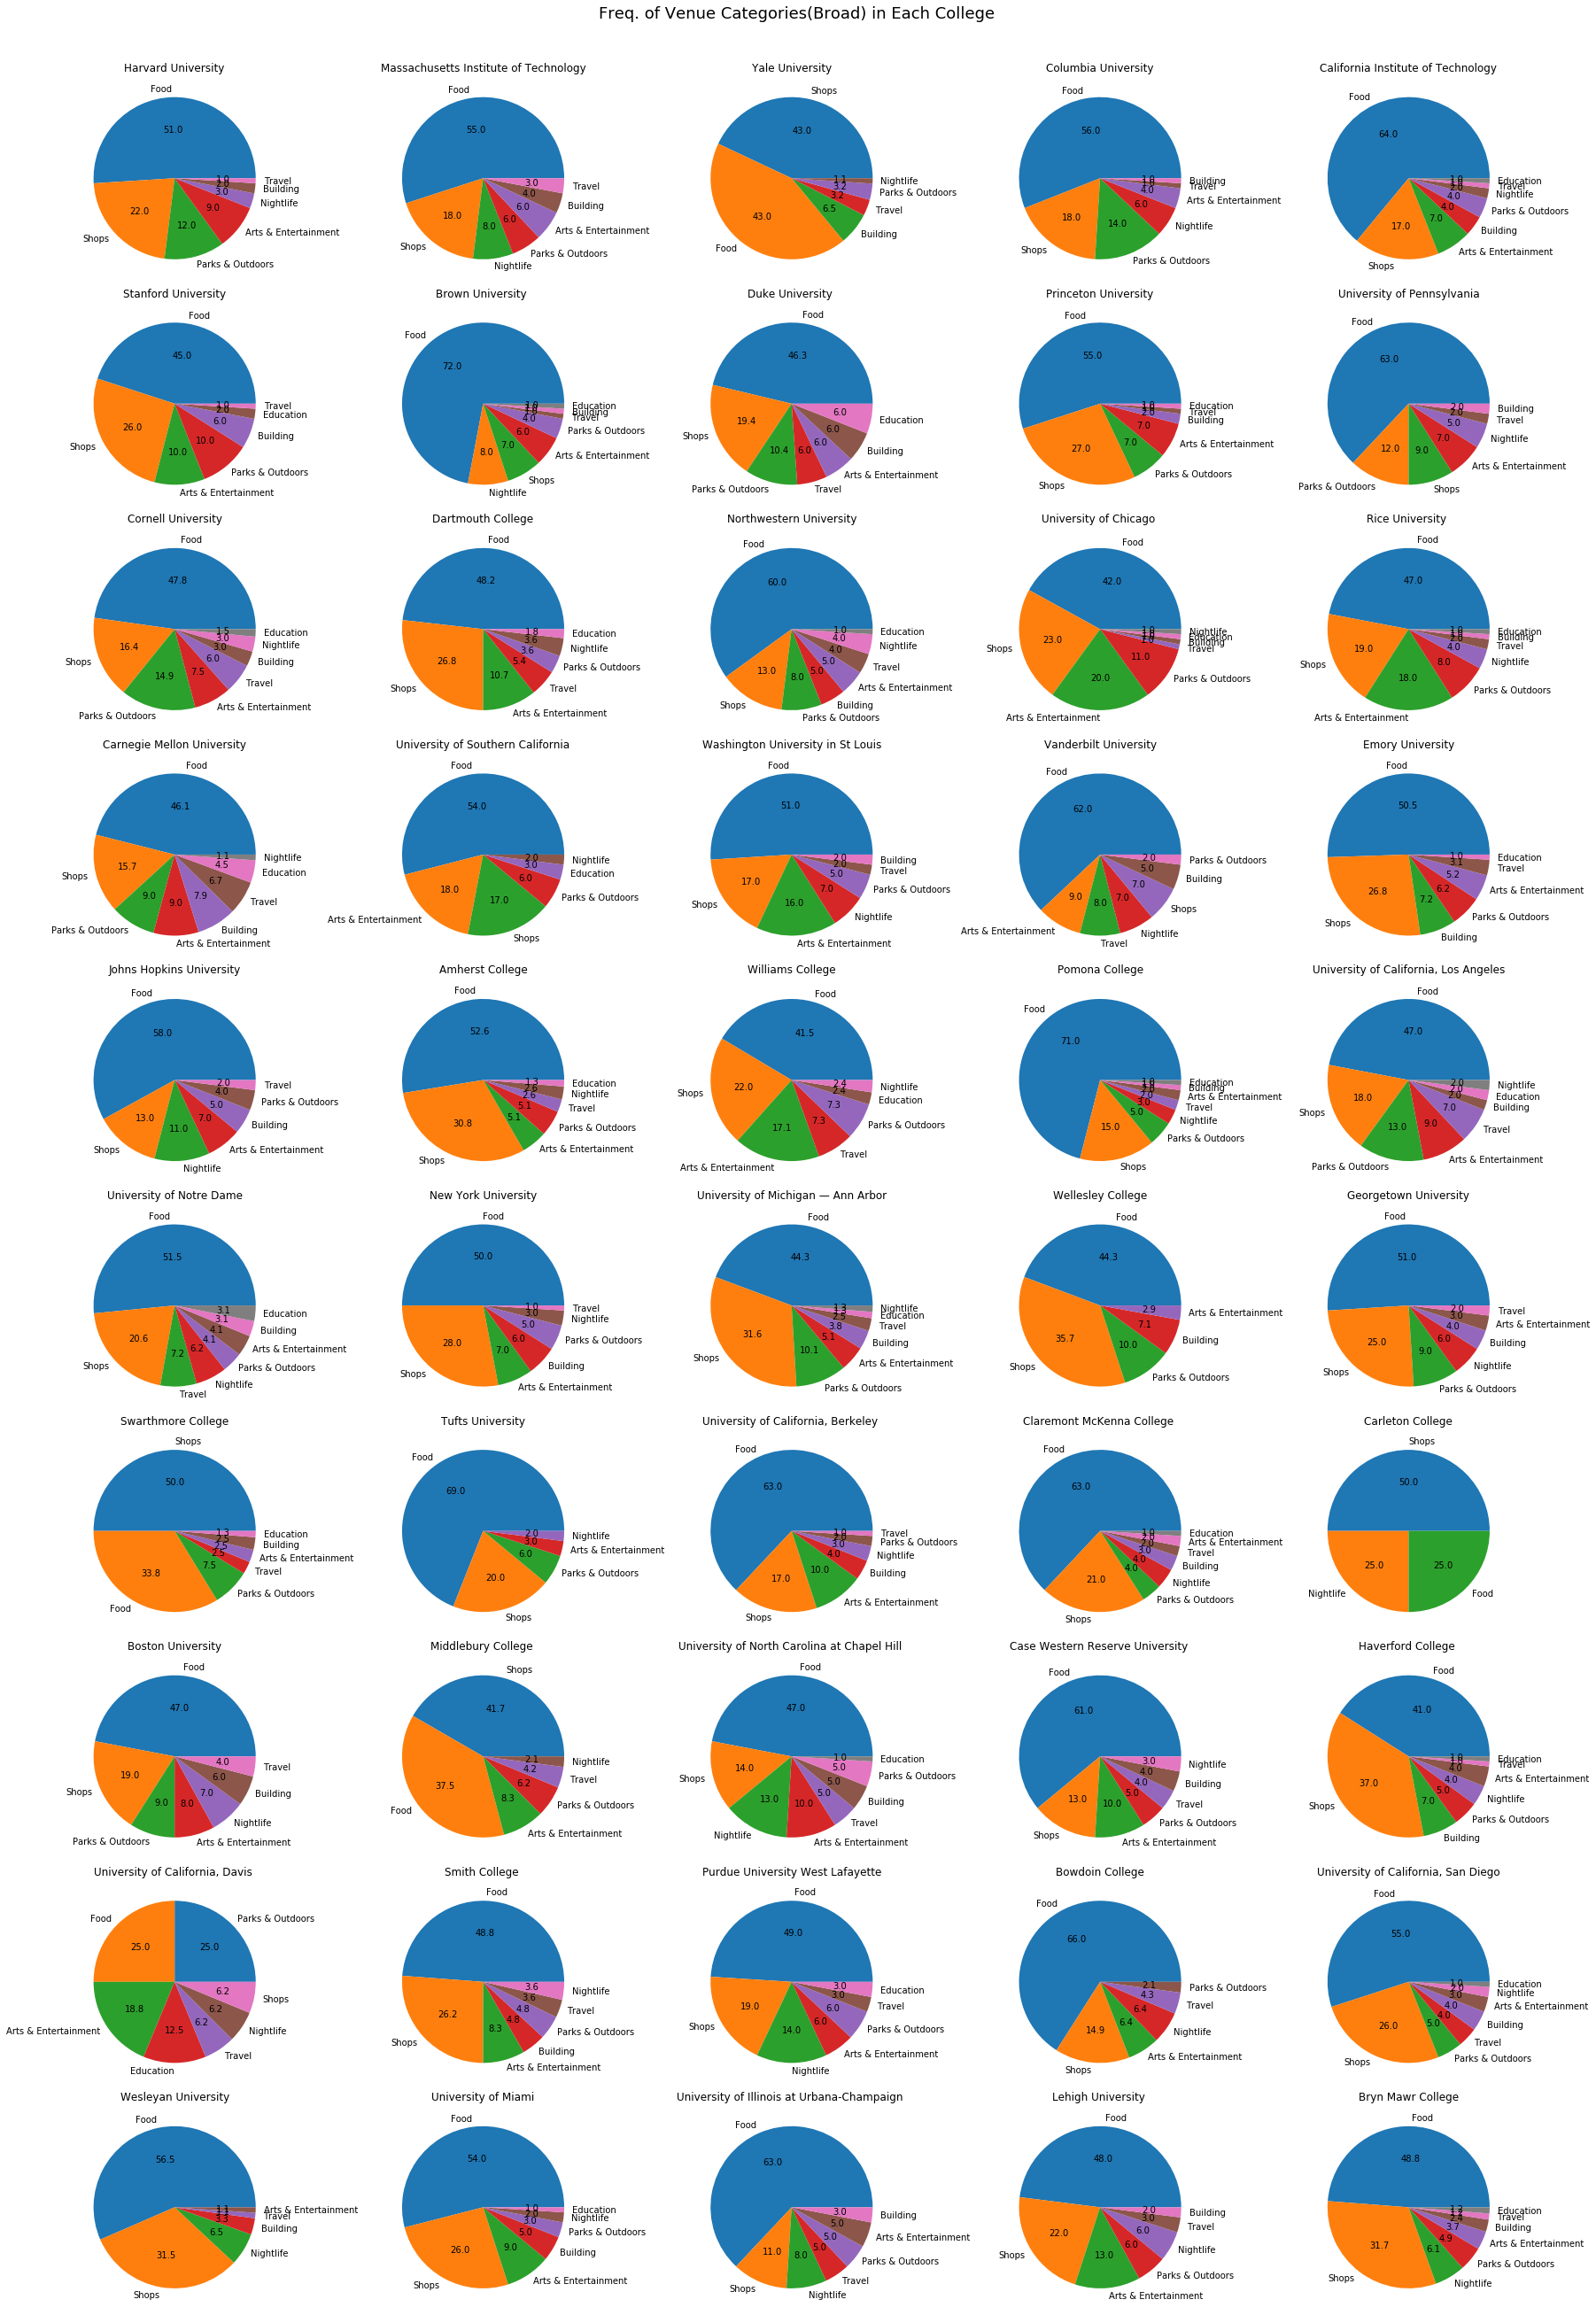

In [95]:
# display freq. of broad venue categories per college
display_freq_venue_cat('Broad', figsize=(25, 37))

The pie charts below show the distribution of __specific__ venue categories for each college. We see that dining venues seem to be dominant across every college. Carleton College appears to have few specific venue categories, which can be explained by the lack of data returned by Foursquare.

Because the pie charts below appear cluttered, Data Frames are also presented below to display the distribution of specific venue categories across colleges.

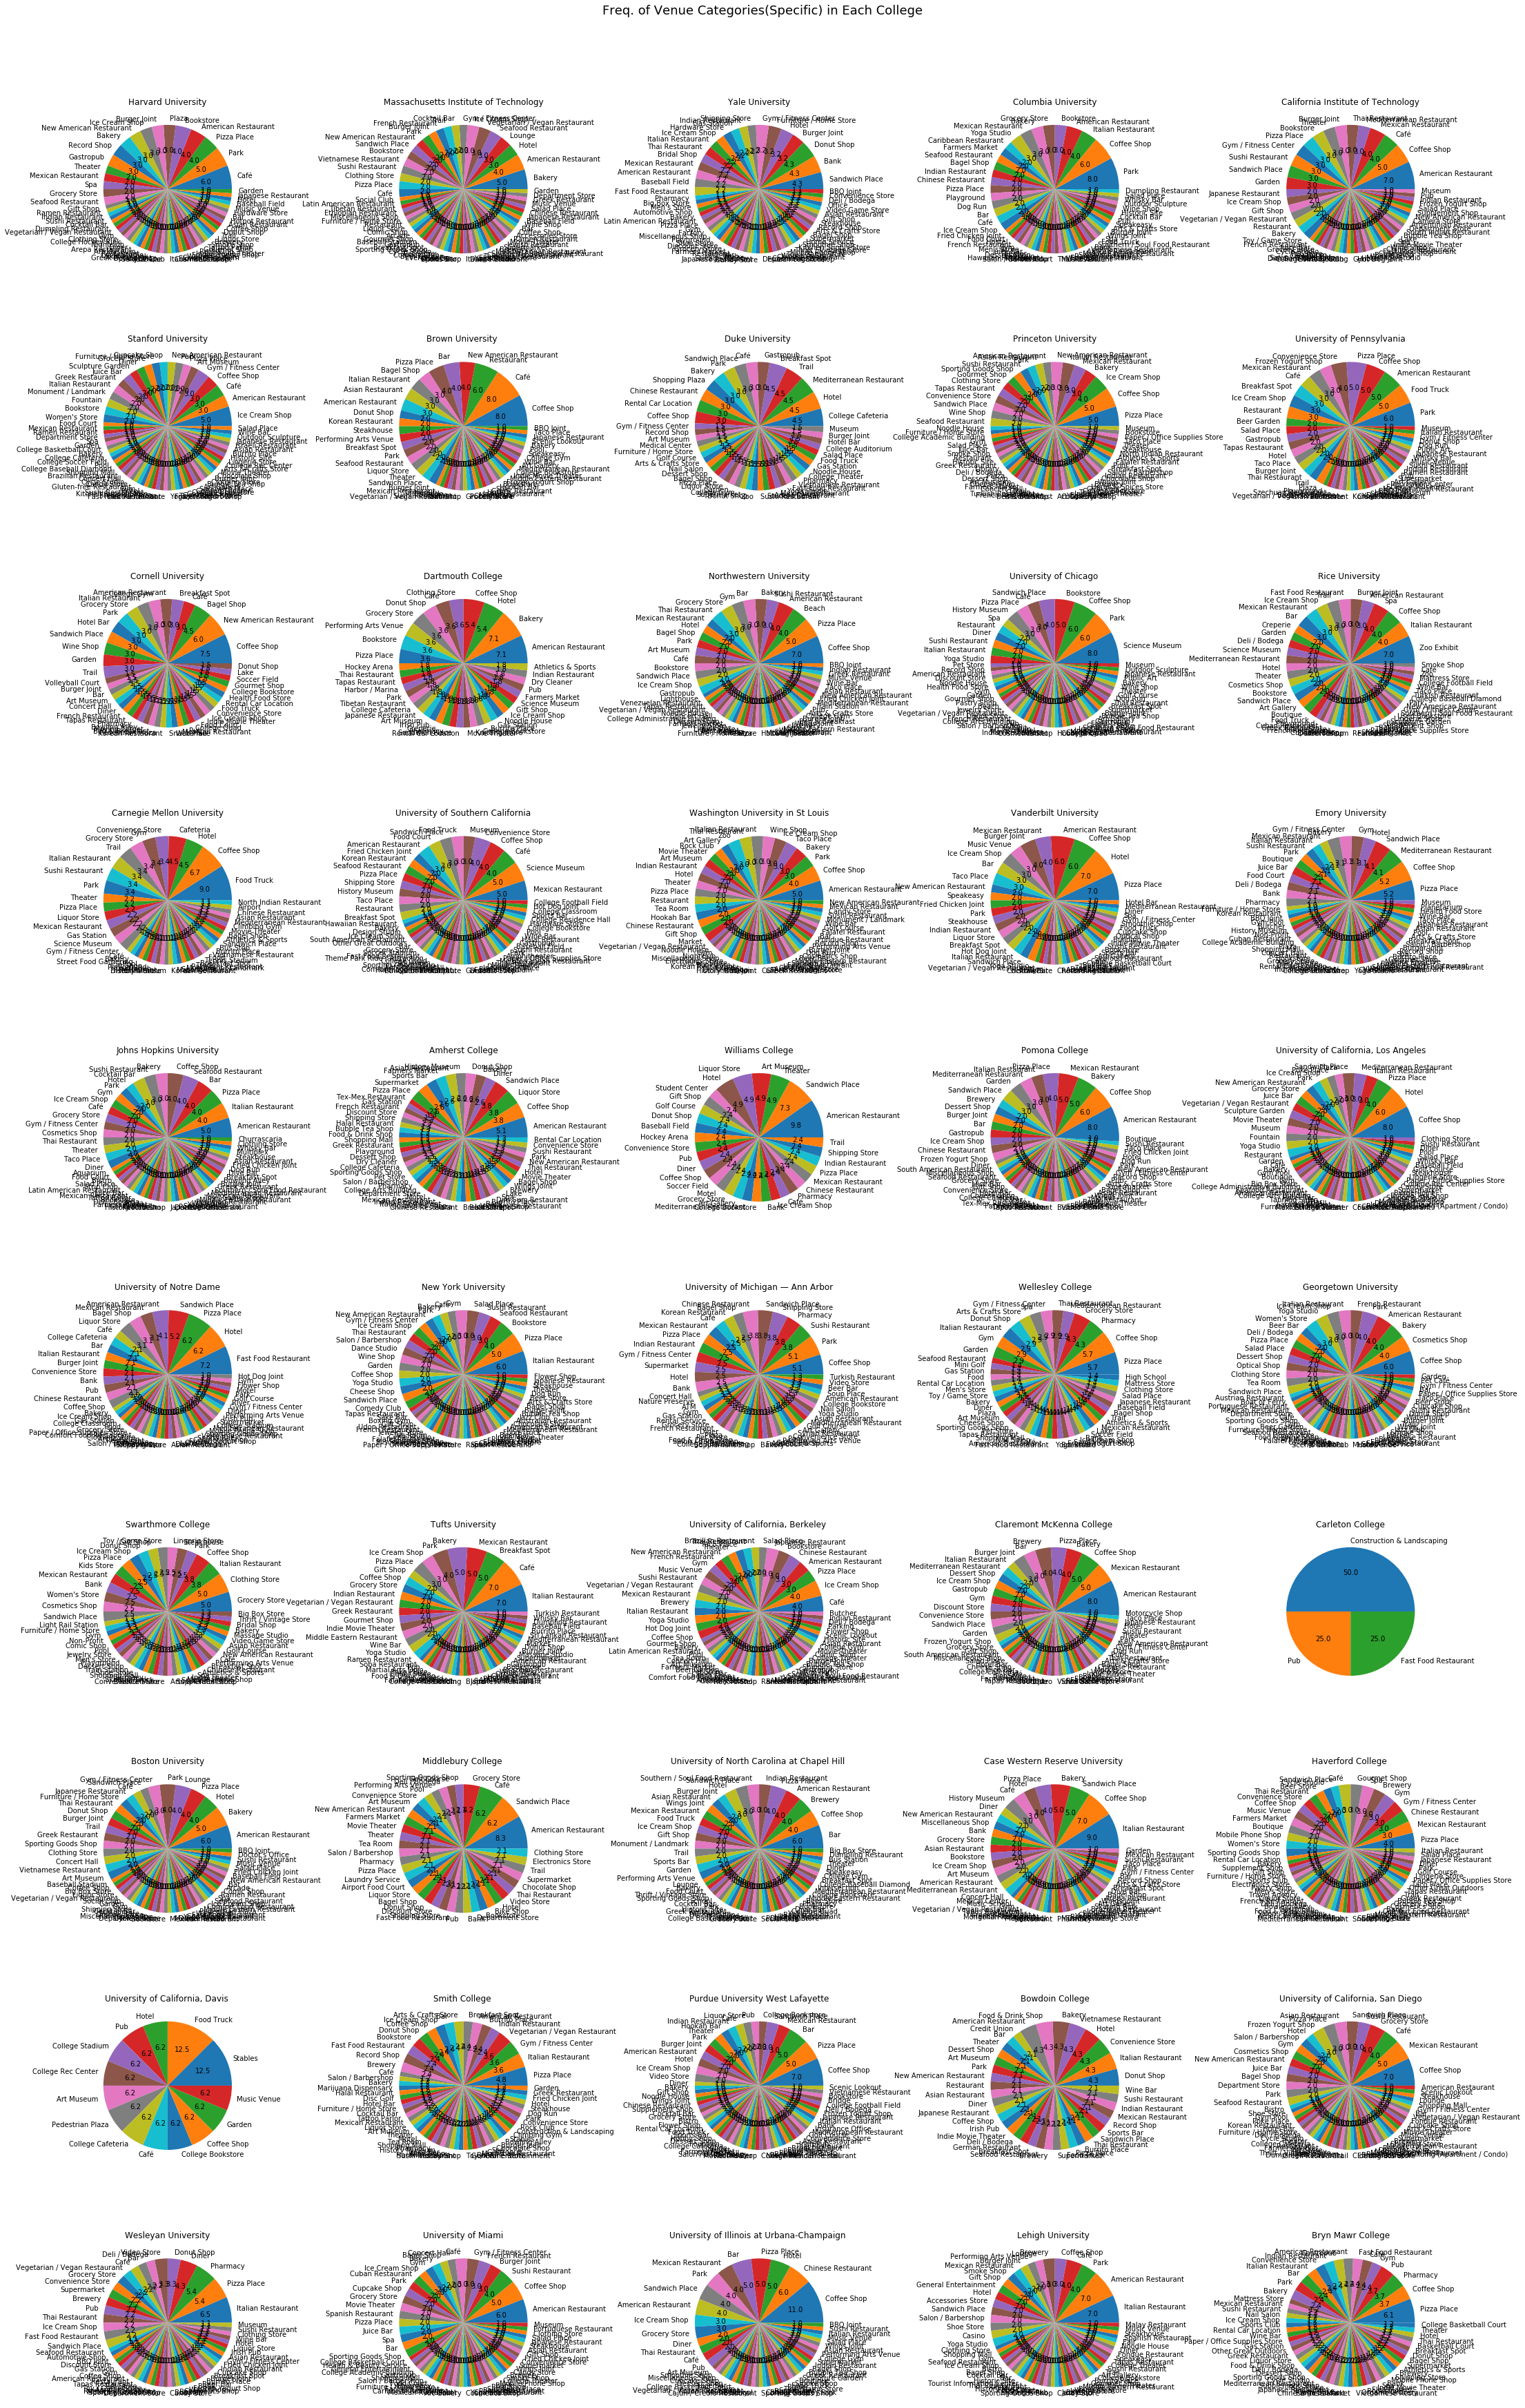

In [26]:
# display freq. of specific venue categories per college
display_freq_venue_cat('Specific', figsize=(30, 50))

In [27]:
# display freq of specific categories for each college in Data Frame, as pie charts above are cluttered
for college, frame in zip(df['College'], display_freq_venue_cat('Specific', mode='df')):
    print(college)
    print(frame.head())
    print()

Harvard University
                     Count
Café                     6
Park                     5
Pizza Place              4
American Restaurant      4
Bookstore                4

Massachusetts Institute of Technology
                     Count
Bakery                   5
American Restaurant      4
Hotel                    3
Lounge                   3
Seafood Restaurant       3

Yale University
                Count
Sandwich Place      4
Bank                4
Donut Shop          4
Burger Joint        3
Hotel               3

Columbia University
                     Count
Park                     8
Coffee Shop              6
Italian Restaurant       4
American Restaurant      4
Bookstore                3

California Institute of Technology
                          Count
American Restaurant           7
Coffee Shop                   5
Café                          4
Mexican Restaurant            4
Mediterranean Restaurant      3

Stanford University
                      Count
Ice Cream

In [29]:
# produces list of Data Frames containing freq. of each venue category/college
list_broad_category_freq_data = display_freq_venue_cat('Broad', mode='df')
list_specific_category_freq_data = display_freq_venue_cat('Specific', mode='df')

In [30]:
# returns list of common venue categories across all colleges 
def find_common_cat(df_list):
    intersection = set(df_list[0].index)
    for df in df_list:
        intersection = intersection & set(df.index)
    return list(intersection)

# displays bar chart of freq. of common venue category across all colleges
def display_common_cat_freq(common_cat, df_list, figsize=(25, 6)):
    frame = pd.DataFrame({cat: [df.loc[cat]['Count'] for df in df_list] for cat in common_cat}, index=df['College'])
    frame.plot.bar(figsize=figsize, title='Frequency of Common Venue Category in Each College')

In [31]:
common_broad_cat = find_common_cat(list_broad_category_freq_data)
common_specific_cat = find_common_cat(list_specific_category_freq_data)

print('Common Broad Categories: ' + str(common_broad_cat))
print('Common Specific Categories: ' + str(common_specific_cat))

Common Broad Categories: ['Food', 'Shops']
Common Specific Categories: []


Shops and food venues are common among all colleges. The appearance of each shop/food venue is displayed in the bar chart below.

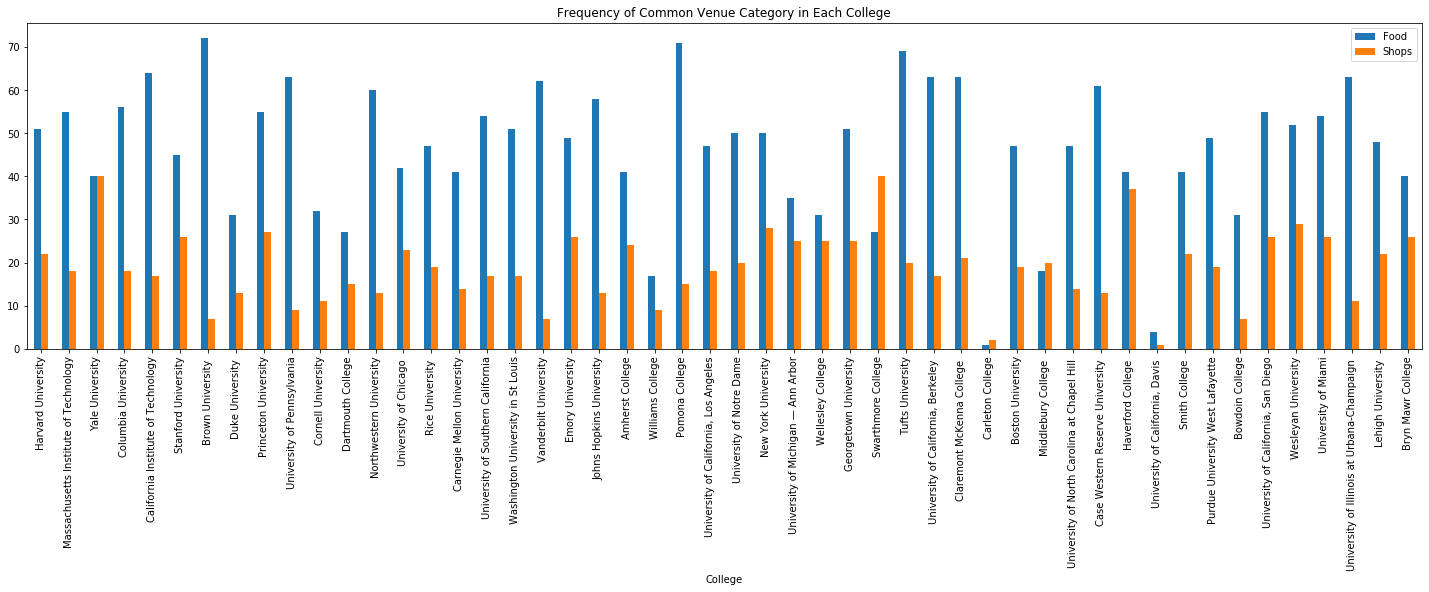

In [32]:
# display bar chart of freq. of broad cat
display_common_cat_freq(common_broad_cat, list_broad_category_freq_data)

In [33]:
# display top 10 most popular venues across all colleges
pop_venues = df_venues['Venue'].value_counts().to_frame()
pop_venues.rename(columns={'Venue':'Count'}, inplace=True)
pop_venues.head(10)

Count
Starbucks                  58
Dunkin'                    22
SUBWAY                     18
CVS pharmacy               17
sweetgreen                 16
Chipotle Mexican Grill     15
Trader Joe's               14
Blaze Pizza                12
7-Eleven                   12
Insomnia Cookies           11

In [34]:
# folium map to visualize college locations
college_loc_map = folium.Map(location=[40, -95], zoom_start=4)

In [35]:
# function to plot point on folium map
def plot_point(coord, map):
    folium.Marker(location=list(coord[0])).add_to(map)

The map below displays the location of each college for reference.

In [36]:
# display folium map
df[['Coordinates']].apply(lambda coord: plot_point(coord, college_loc_map), axis=1)
college_loc_map

## Cluster Modeling

Because we have established the distinction between __broad__ and __specific__ venue categories, we will cluster twice and explore which model delivers the most useful information.

In [38]:
# one-hot encoding
onehot = pd.get_dummies(df_venues[['Broad Category']], prefix="", prefix_sep="")
onehot['College'] = df_venues['College']
onehot = onehot.set_index('College')
onehot.head()

Arts & Entertainment  Building  Education  Food  \
College                                                               
Harvard University                     1         0          0     0   
Harvard University                     0         0          0     0   
Harvard University                     0         0          0     0   
Harvard University                     0         0          0     1   
Harvard University                     0         0          0     0   

                    Nightlife  Parks & Outdoors  Shops  Travel  
College                                                         
Harvard University          0                 0      0       0  
Harvard University          0                 0      1       0  
Harvard University          0                 1      0       0  
Harvard University          0                 0      0       0  
Harvard University          1                 0      0       0

In [39]:
# group one-hot encoded table by college
onehot_mean = onehot.groupby(onehot.index).mean().reset_index()
onehot_mean.head()

College  Arts & Entertainment  Building  Education      Food  \
0    Amherst College              0.051282   0.00000   0.012821  0.525641   
1  Boston University              0.080000   0.06000   0.000000  0.470000   
2    Bowdoin College              0.063830   0.00000   0.000000  0.659574   
3  Brown University               0.060000   0.01000   0.010000  0.720000   
4  Bryn Mawr College              0.036585   0.02439   0.012195  0.487805   

   Nightlife  Parks & Outdoors     Shops    Travel  
0   0.025641          0.051282  0.307692  0.025641  
1   0.070000          0.090000  0.190000  0.040000  
2   0.063830          0.021277  0.148936  0.042553  
3   0.080000          0.040000  0.070000  0.010000  
4   0.060976          0.048780  0.317073  0.012195

The elbow curve below suggests that it is optimal to use between 2 and 6 clusters. In a later cell, we run the model several times for different numbers of clusters and explore the results. 

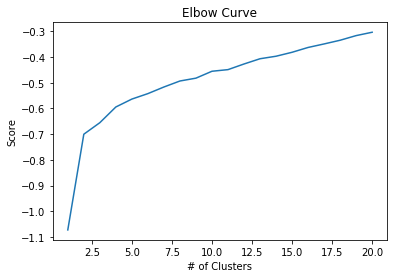

In [97]:
num_clusters = [i for i in range(1, 21)]
X_train = onehot_mean.drop('College', axis=1)
kmeans = [KMeans(n_clusters=i) for i in num_clusters]
scores = [kmeans[i].fit(X_train).score(X_train) for i in range(len(kmeans))]

plt.plot(num_clusters, scores)
plt.xlabel('# of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [101]:
k = 3 # from elbow curve
kmeans = KMeans(n_clusters=k).fit(X_train)
kmeans.labels_

array([1, 1, 1, 1, 1, 1, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1], dtype=int32)

In [102]:
# create new Data Frame with relevant information and cluster labels
clustered_df_broad = pd.DataFrame(columns=['College', 'Tuition', 'Coordinates', 'Cluster Labels', 'Category 1', 'Category 2', 'Category 3', 'Category 4', 'Category 5']) 
clustered_df_broad['College'] = df['College']
clustered_df_broad['Tuition'] = df['Average Tuition']
clustered_df_broad['Coordinates'] = df['Coordinates']
clustered_df_broad['Cluster Labels'] = kmeans.labels_
list_freq_df = display_freq_venue_cat('Broad', mode='df')
for i in range(5):
    clustered_df_broad['Category ' + str(i + 1)] = ['None' if (i + 1) > len(df.index) else df.index[i] for df in list_freq_df] # conditional needed for colleges not having 5 top venue categories

clustered_df_broad

College  Tuition  \
0                             Harvard University    16205   
1          Massachusetts Institute of Technology    21576   
2                                Yale University    18319   
3                            Columbia University    22973   
4             California Institute of Technology    26839   
5                            Stanford University    16695   
6                              Brown University     25264   
7                               Duke University     19950   
8                           Princeton University    17732   
9                     University of Pennsylvania    22944   
10                            Cornell University    30014   
11                             Dartmouth College    21177   
12                       Northwestern University    29326   
13                        University of Chicago     31068   
14                              Rice University     22061   
15                    Carnegie Mellon University    35250   
16             University of Southern California    32932   
17             Washington University in St Louis    28824   
18                         Vanderbilt University    23150   
19                              Emory University    24804   
20                      Johns Hopkins University    27352   
21                               Amherst College    19055   
22                              Williams College    18167   
23                                Pomona College    18140   
24         University of California, Los Angeles    14236   
25                      University of Notre Dame    26683   
26                           New York University    35147   
27            University of Michigan — Ann Arbor    16107   
28                             Wellesley College    20013   
29                         Georgetown University    26625   
30                            Swarthmore College    19641   
31                              Tufts University    28076   
32           University of California, Berkeley     17160   
33                    Claremont McKenna College     30527   
34                              Carleton College    28587   
35                             Boston University    31539   
36                           Middlebury College     21437   
37  University of North Carolina at Chapel Hill     10077   
38              Case Western Reserve University     33124   
39                            Haverford College     21144   
40              University of California, Davis     16039   
41                                Smith College     24258   
42              Purdue University West Lafayette    11693   
43                               Bowdoin College    24888   
44           University of California, San Diego    14770   
45                           Wesleyan University    20490   
46                           University of Miami    37424   
47   University of Illinois at Urbana-Champaign     16683   
48                            Lehigh University     27478   
49                             Bryn Mawr College    31900   

                         Coordinates  Cluster Labels        Category 1  \
0   (42.36782045, -71.1266665287448)               1              Food   
1    (42.3583961, -71.0956778766393)               1              Food   
2   (41.25713055, -72.9896696015223)               1             Shops   
3    (40.8071772, -73.9625279772072)               1              Food   
4   (34.13710185, -118.125274866116)               1              Food   
5   (37.43131385, -122.169365354983)               1              Food   
6   (41.82687235, -71.4012277069681)               2              Food   
7    (36.0001557, -78.9442297219588)               0              Food   
8        (40.34829285, -74.66308325)               1              Food   
9     (39.9492344, -75.191989851901)               1              Food   
10   (42.4505507, -76.4783512955428)               1              Food   
11         (43.7047927, -72.2925909)     

In [103]:
# create map to visualize the clusters
map_clusters = folium.Map(location=[40, -95], zoom_start=4)

# set color scheme for the clusters
x = np.arange(k)
ys = [i+x+(i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for coord, college, tuition, cluster in zip(clustered_df_broad['Coordinates'], clustered_df_broad['College'], clustered_df_broad['Tuition'], clustered_df_broad['Cluster Labels']):
    label = folium.Popup('College: ' + str(college) + ', Tuition: $' + str(tuition) + ', Cluster: ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        coord,
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
    
map_clusters

The cell below has been used to run the cluster model 50 times with different numbers of clusters. The results are saved in the local directory.

In [46]:
# from random import randint
# for counter in range(50):
#     k = randint(3, 6) # from elbow curve
#     kmeans = KMeans(n_clusters=k).fit(X_train)
#     kmeans.labels_
    
#     # create new Data Frame with relevant information and cluster labels
#     clustered_df_broad = pd.DataFrame(columns=['College', 'Tuition', 'Coordinates', 'Cluster Labels', 'Category 1', 'Category 2', 'Category 3', 'Category 4', 'Category 5']) 
#     clustered_df_broad['College'] = df['College']
#     clustered_df_broad['Tuition'] = df['Average Tuition']
#     clustered_df_broad['Coordinates'] = df['Coordinates']
#     clustered_df_broad['Cluster Labels'] = kmeans.labels_
#     list_freq_df = display_freq_venue_cat('Broad', mode='df')
#     for i in range(5):
#         clustered_df_broad['Category ' + str(i + 1)] = ['None' if (i + 1) > len(df.index) else df.index[i] for df in list_freq_df] # conditional needed for colleges not having 5 top venue categories
#     clustered_df_broad.to_csv('/Users/Aman/Documents/Jupyter Notebooks/Coursera Capstone/Clustered Data Frames/Broad/df{}(k{}).csv'.format(counter, k))
    
#     # create map to visualize the clusters
#     map_clusters = folium.Map(location=[40, -95], zoom_start=4)

#     # set color scheme for the clusters
#     x = np.arange(k)
#     ys = [i+x+(i*x)**2 for i in range(k)]
#     colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
#     rainbow = [colors.rgb2hex(i) for i in colors_array]

#     # add markers to the map
#     markers_colors = []
#     for coord, college, tuition, cluster in zip(clustered_df_broad['Coordinates'], clustered_df_broad['College'], clustered_df_broad['Tuition'], clustered_df_broad['Cluster Labels']):
#         label = folium.Popup('College: ' + str(college) + ', Tuition: $' + str(tuition) + ', Cluster: ' + str(cluster), parse_html=True)
#         folium.CircleMarker(
#             coord,
#             radius=5,
#             popup=label,
#             color=rainbow[cluster-1],
#             fill=True,
#             fill_color=rainbow[cluster-1],
#             fill_opacity=0.7).add_to(map_clusters)

#     map_clusters.save('/Users/Aman/Documents/Jupyter Notebooks/Coursera Capstone/Maps/Broad/map{}(k{}).html'.format(counter, k))

We will now repeat the clustering process to explore clusters of specific venue categories.

In [47]:
# one-hot encoding
onehot = pd.get_dummies(df_venues[['Specific Category']], prefix="", prefix_sep="")
onehot['College'] = df_venues['College']
onehot = onehot.set_index('College')
onehot.head()

ATM  Accessories Store  African Restaurant  Airport  \
College                                                                   
Harvard University    0                  0                   0        0   
Harvard University    0                  0                   0        0   
Harvard University    0                  0                   0        0   
Harvard University    0                  0                   0        0   
Harvard University    0                  0                   0        0   

                    Airport Food Court  American Restaurant  Amphitheater  \
College                                                                     
Harvard University                   0                    0             0   
Harvard University                   0                    0             0   
Harvard University                   0                    0             0   
Harvard University                   0                    0             0   
Harvard University                   0                    0             0   

                    Animal Shelter  Aquarium  Arcade  ...  Waterfall  \
College                                               ...              
Harvard University               0         0       0  ...          0   
Harvard University               0         0       0  ...          0   
Harvard University               0         0       0  ...          0   
Harvard University               0         0       0  ...          0   
Harvard University               0         0       0  ...          0   

                    Waterfront  Whisky Bar  Wine Bar  Wine Shop  Wings Joint  \
College                                                                        
Harvard University           0           0         0          0            0   
Harvard University           0           0         0          0            0   
Harvard University           0           0         0          0            0   
Harvard University           0           0         0          0            0   
Harvard University           0           0         0          0            0   

                    Women's Store  Yoga Studio  Zoo  Zoo Exhibit  
College                                                           
Harvard University              0            0    0            0  
Harvard University              0            0    0            0  
Harvard University              0            0    0            0  
Harvard University              0            0    0            0  
Harvard University              0            0    0            0  

[5 rows x 361 columns]

In [48]:
# group one-hot encoded table by college
onehot_mean = onehot.groupby(onehot.index).mean().reset_index()
onehot_mean.head()

College  ATM  Accessories Store  African Restaurant  Airport  \
0    Amherst College  0.0                0.0                 0.0      0.0   
1  Boston University  0.0                0.0                 0.0      0.0   
2    Bowdoin College  0.0                0.0                 0.0      0.0   
3  Brown University   0.0                0.0                 0.0      0.0   
4  Bryn Mawr College  0.0                0.0                 0.0      0.0   

   Airport Food Court  American Restaurant  Amphitheater  Animal Shelter  \
0                 0.0             0.051282           0.0             0.0   
1                 0.0             0.060000           0.0             0.0   
2                 0.0             0.042553           0.0             0.0   
3                 0.0             0.030000           0.0             0.0   
4                 0.0             0.024390           0.0             0.0   

   Aquarium  ...  Waterfall  Waterfront  Whisky Bar  Wine Bar  Wine Shop  \
0       0.0  ...        0.0         0.0         0.0  0.000000       0.00   
1       0.0  ...        0.0         0.0         0.0  0.000000       0.01   
2       0.0  ...        0.0         0.0         0.0  0.021277       0.00   
3       0.0  ...        0.0         0.0         0.0  0.010000       0.00   
4       0.0  ...        0.0         0.0         0.0  0.012195       0.00   

   Wings Joint  Women's Store  Yoga Studio  Zoo  Zoo Exhibit  
0     0.012821            0.0     0.000000  0.0          0.0  
1     0.000000            0.0     0.010000  0.0          0.0  
2     0.000000            0.0     0.000000  0.0          0.0  
3     0.000000            0.0     0.000000  0.0          0.0  
4     0.000000            0.0     0.012195  0.0          0.0  

[5 rows x 362 columns]

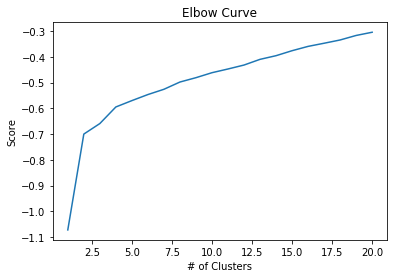

In [49]:
num_clusters = [i for i in range(1, 21)]
X_train = onehot_mean.drop('College', axis=1)
kmeans = [KMeans(n_clusters=i) for i in num_clusters]
scores = [kmeans[i].fit(X_train).score(X_train) for i in range(len(kmeans))]

plt.plot(num_clusters, scores)
plt.xlabel('# of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [50]:
k = 2 # from elbow curve
kmeans = KMeans(n_clusters=k).fit(X_train)
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=int32)

In [51]:
# create new Data Frame with relevant information and cluster labels
clustered_df_specific = pd.DataFrame(columns=['College', 'Tuition', 'Coordinates', 'Cluster Labels', 'Category 1', 'Category 2', 'Category 3', 'Category 4', 'Category 5', 'Category 6', 'Category 7', 'Category 8', 'Category 9', 'Category 10']) 
clustered_df_specific['College'] = df['College']
clustered_df_specific['Tuition'] = df['Average Tuition']
clustered_df_specific['Coordinates'] = df['Coordinates']
clustered_df_specific['Cluster Labels'] = kmeans.labels_
list_freq_df = display_freq_venue_cat('Specific', mode='df')
for i in range(10):
    clustered_df_specific['Category ' + str(i + 1)] = ['None' if (i + 1) > len(df.index) else df.index[i] for df in list_freq_df] # conditional needed for colleges not having 5 top venue categories
clustered_df_specific

College  Tuition  \
0                             Harvard University    16205   
1          Massachusetts Institute of Technology    21576   
2                                Yale University    18319   
3                            Columbia University    22973   
4             California Institute of Technology    26839   
5                            Stanford University    16695   
6                              Brown University     25264   
7                               Duke University     19950   
8                           Princeton University    17732   
9                     University of Pennsylvania    22944   
10                            Cornell University    30014   
11                             Dartmouth College    21177   
12                       Northwestern University    29326   
13                        University of Chicago     31068   
14                              Rice University     22061   
15                    Carnegie Mellon University    35250   
16             University of Southern California    32932   
17             Washington University in St Louis    28824   
18                         Vanderbilt University    23150   
19                              Emory University    24804   
20                      Johns Hopkins University    27352   
21                               Amherst College    19055   
22                              Williams College    18167   
23                                Pomona College    18140   
24         University of California, Los Angeles    14236   
25                      University of Notre Dame    26683   
26                           New York University    35147   
27            University of Michigan — Ann Arbor    16107   
28                             Wellesley College    20013   
29                         Georgetown University    26625   
30                            Swarthmore College    19641   
31                              Tufts University    28076   
32           University of California, Berkeley     17160   
33                    Claremont McKenna College     30527   
34                              Carleton College    28587   
35                             Boston University    31539   
36                           Middlebury College     21437   
37  University of North Carolina at Chapel Hill     10077   
38              Case Western Reserve University     33124   
39                            Haverford College     21144   
40              University of California, Davis     16039   
41                                Smith College     24258   
42              Purdue University West Lafayette    11693   
43                               Bowdoin College    24888   
44           University of California, San Diego    14770   
45                           Wesleyan University    20490   
46                           University of Miami    37424   
47   University of Illinois at Urbana-Champaign     16683   
48                            Lehigh University     27478   
49                             Bryn Mawr College    31900   

                         Coordinates  Cluster Labels  \
0   (42.36782045, -71.1266665287448)               0   
1    (42.3583961, -71.0956778766393)               0   
2   (41.25713055, -72.9896696015223)               0   
3    (40.8071772, -73.9625279772072)               0   
4   (34.13710185, -118.125274866116)               0   
5   (37.43131385, -122.169365354983)               0   
6   (41.82687235, -71.4012277069681)               1   
7    (36.0001557, -78.9442297219588)               0   
8        (40.34829285, -74.66308325)               0   
9     (39.9492344, -75.191989851901)               0   
10   (42.4505507, -76.4783512955428)               0   
11         (43.7047927, -72.2925909)               0   
12   (42.0551164, -87.6758111348217)               0   
13  (41.78468745, -87.6007493265106)               0   
14  (29.71679145, -95.4047811339379)               0   
15   (37.4102193, -122.0596548658

In [52]:
# create map to visualize the clusters
map_clusters = folium.Map(location=[40, -95], zoom_start=4)

# set color scheme for the clusters
x = np.arange(k)
ys = [i+x+(i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for coord, college, tuition, cluster in zip(clustered_df_specific['Coordinates'], clustered_df_specific['College'], clustered_df_specific['Tuition'], clustered_df_specific['Cluster Labels']):
    label = folium.Popup('College: ' + str(college) + ', Tuition: $' + str(tuition) + ', Cluster: ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        coord,
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
    
map_clusters

The cell below has been used to run the cluster model 50 times with different numbers of clusters. The results are saved in the local directory.

In [53]:
# from random import randint
# for counter in range(50):
#     k = randint(3, 5) # from elbow curve
#     kmeans = KMeans(n_clusters=k).fit(X_train)
#     kmeans.labels_
    
#     # create new Data Frame with relevant information and cluster labels
#     clustered_df_specific = pd.DataFrame(columns=['College', 'Tuition', 'Coordinates', 'Cluster Labels', 'Category 1', 'Category 2', 'Category 3', 'Category 4', 'Category 5', 'Category 6', 'Category 7', 'Category 8', 'Category 9', 'Category 10']) 
#     clustered_df_specific['College'] = df['College']
#     clustered_df_specific['Tuition'] = df['Average Tuition']
#     clustered_df_specific['Coordinates'] = df['Coordinates']
#     clustered_df_specific['Cluster Labels'] = kmeans.labels_
#     list_freq_df = display_freq_venue_cat('Specific', mode='df')
#     for i in range(10):
#         clustered_df_specific['Category ' + str(i + 1)] = ['None' if (i + 1) > len(df.index) else df.index[i] for df in list_freq_df] # conditional needed for colleges not having 5 top venue categories
#     clustered_df_broad.to_csv('/Users/Aman/Documents/Jupyter Notebooks/Coursera Capstone/Clustered Data Frames/Specific/df{}(k{}).csv'.format(counter, k))
    
#     # create map to visualize the clusters
#     map_clusters = folium.Map(location=[40, -95], zoom_start=4)

#     # set color scheme for the clusters
#     x = np.arange(k)
#     ys = [i+x+(i*x)**2 for i in range(k)]
#     colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
#     rainbow = [colors.rgb2hex(i) for i in colors_array]

#     # add markers to the map
#     markers_colors = []
#     for coord, college, tuition, cluster in zip(clustered_df_specific['Coordinates'], clustered_df_specific['College'], clustered_df_specific['Tuition'], clustered_df_specific['Cluster Labels']):
#         label = folium.Popup('College: ' + str(college) + ', Tuition: $' + str(tuition) + ', Cluster: ' + str(cluster), parse_html=True)
#         folium.CircleMarker(
#             coord,
#             radius=5,
#             popup=label,
#             color=rainbow[cluster-1],
#             fill=True,
#             fill_color=rainbow[cluster-1],
#             fill_opacity=0.7).add_to(map_clusters)

#     map_clusters.save('/Users/Aman/Documents/Jupyter Notebooks/Coursera Capstone/Maps/Specific/map{}(k{}).html'.format(counter, k))

## Cluster Analysis & Results

Using the above 2 clustered Data Frames for __broad__ & __specific__ venue categories, analyzing similarities between colleges and venues in the same cluster will provide insight into interpretting each cluster.

### Broad Venue Categories

In [104]:
clustered_df_broad = clustered_df_broad.sort_values('Cluster Labels').reset_index(drop=True)

College  Tuition                      Coordinates  \
0             Bowdoin College    24888  (43.9075035, -69.9617742423256)   
1            Duke University     19950  (36.0001557, -78.9442297219588)   
2  Claremont McKenna College     30527       (34.1023497, -117.7067162)   
3         Middlebury College     21437        (44.0090777, -73.1767946)   

   Cluster Labels Category 1 Category 2            Category 3  \
0               0       Food      Shops  Arts & Entertainment   
1               0       Food      Shops      Parks & Outdoors   
2               0       Food      Shops      Parks & Outdoors   
3               0      Shops       Food  Arts & Entertainment   

         Category 4            Category 5  
0         Nightlife                Travel  
1            Travel  Arts & Entertainment  
2         Nightlife              Building  
3  Parks & Outdoors                Travel

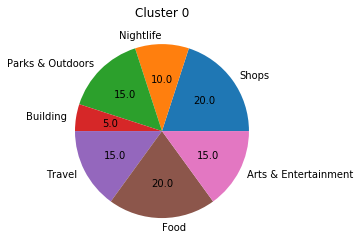

College  Tuition  \
4                             Harvard University    16205   
5             University of Michigan — Ann Arbor    16107   
6                              Wellesley College    20013   
7                          Georgetown University    26625   
8                             Swarthmore College    19641   
9                               Tufts University    28076   
10           University of California, Berkeley     17160   
11                              Carleton College    28587   
12                             Boston University    31539   
13  University of North Carolina at Chapel Hill     10077   
14              Case Western Reserve University     33124   
15                            Haverford College     21144   
16              University of California, Davis     16039   
17                                Smith College     24258   
18              Purdue University West Lafayette    11693   
19           University of California, San Diego    14770   
20                           Wesleyan University    20490   
21                           University of Miami    37424   
22   University of Illinois at Urbana-Champaign     16683   
23                           New York University    35147   
24                      University of Notre Dame    26683   
25         University of California, Los Angeles    14236   
26                                Pomona College    18140   
27         Massachusetts Institute of Technology    21576   
28                               Yale University    18319   
29                           Columbia University    22973   
30            California Institute of Technology    26839   
31                           Stanford University    16695   
32                          Princeton University    17732   
33                    University of Pennsylvania    22944   
34                            Cornell University    30014   
35                             Dartmouth College    21177   
36                            Lehigh University     27478   
37                       Northwestern University    29326   
38                              Rice University     22061   
39                    Carnegie Mellon University    35250   
40             University of Southern California    32932   
41             Washington University in St Louis    28824   
42                         Vanderbilt University    23150   
43                              Emory University    24804   
44                      Johns Hopkins University    27352   
45                               Amherst College    19055   
46                              Williams College    18167   
47                        University of Chicago     31068   
48                             Bryn Mawr College    31900   

                         Coordinates  Cluster Labels        Category 1  \
4   (42.36782045, -71.1266665287448)               1              Food   
5     (42.2942142, -83.710038935096)               1              Food   
6   (42.29182055, -71.3033260683231)               1              Food   
7   (38.90893925, -77.0745796206083)               1              Food   
8     (39.9035501, -75.354092055757)               1             Shops   
9   (42.40629165, -71.1197504981564)               1              Food   
10  (37.87094645, -122.266398722925)               1              Food   
11  (44.47183535, -93.1414580590152)               1             Shops   
12  (42.35050035, -71.1025599049017)               1              Food   
13  (35.90503535, -79.0477532652511)               1              Food   
14  (41.50138695, -81.6007021615902)               1              Food   
15   (40.0071506, -75.3069423257631)               1              Food   
16  (38.52247515, -121.751392674913)               1  Parks & Outdoors   
17         (42.3148532, -72.6401382)               1              Food   
18         (40.4275052, -86.9122769)               1              Food   
19  (32.87935255, -117.231100493855)              

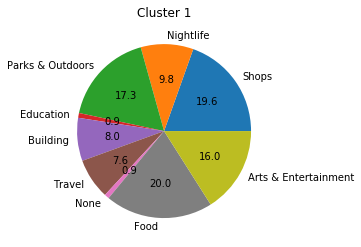

College  Tuition                       Coordinates  \
49  Brown University     25264  (41.82687235, -71.4012277069681)   

    Cluster Labels Category 1 Category 2 Category 3            Category 4  \
49               2       Food  Nightlife      Shops  Arts & Entertainment   

          Category 5  
49  Parks & Outdoors

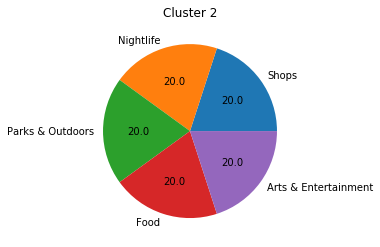

In [105]:
from IPython.display import display
for i in range(len(sorted(clustered_df_broad['Cluster Labels'].unique()))):
    #print('Cluster {}'.format(i + 1))
    display(clustered_df_broad[clustered_df_broad['Cluster Labels'] == i])
    categories = clustered_df_broad[clustered_df_broad['Cluster Labels'] == i][['Category 1', 'Category 2', 'Category 3', 'Category 4', 'Category 5']].values.flatten().tolist()
    vals = [categories.count(cat) for cat in set(categories)]
    plt.pie(vals, labels=list(set(categories)), autopct='%.1f')
    plt.title('Cluster {}'.format(i))
    plt.show()

Upon examing the above tables, each cluster can be interpreted based on the types of venues. Each cluster appears to have Food and Shops as the top 2 venue categories. They differentiate mostly based on the latter 3 categories.

__Cluster 0:__ contains majority of venues in Travel   
__Cluster 1:__ contains all venues in Education and majority in Building    
__Cluster 2:__ contains majority of venues in Nightlife, Arts & Entertainment, and Parks & Outdoors

### Specific Venue Categories

In [56]:
clustered_df_specific = clustered_df_specific.sort_values('Cluster Labels').reset_index(drop=True)

College  Tuition  \
0                             Harvard University    16205   
1             University of Michigan — Ann Arbor    16107   
2                              Wellesley College    20013   
3                          Georgetown University    26625   
4                             Swarthmore College    19641   
5                               Tufts University    28076   
6            University of California, Berkeley     17160   
7                     Claremont McKenna College     30527   
8                               Carleton College    28587   
9                              Boston University    31539   
10                           Middlebury College     21437   
11  University of North Carolina at Chapel Hill     10077   
12              Case Western Reserve University     33124   
13                            Haverford College     21144   
14              University of California, Davis     16039   
15                                Smith College     24258   
16              Purdue University West Lafayette    11693   
17                               Bowdoin College    24888   
18           University of California, San Diego    14770   
19                           Wesleyan University    20490   
20                           University of Miami    37424   
21   University of Illinois at Urbana-Champaign     16683   
22                           New York University    35147   
23                      University of Notre Dame    26683   
24         University of California, Los Angeles    14236   
25                                Pomona College    18140   
26         Massachusetts Institute of Technology    21576   
27                               Yale University    18319   
28                           Columbia University    22973   
29            California Institute of Technology    26839   
30                           Stanford University    16695   
31                              Duke University     19950   
32                          Princeton University    17732   
33                    University of Pennsylvania    22944   
34                            Cornell University    30014   
35                            Lehigh University     27478   
36                             Dartmouth College    21177   
37                        University of Chicago     31068   
38                              Rice University     22061   
39                    Carnegie Mellon University    35250   
40             University of Southern California    32932   
41             Washington University in St Louis    28824   
42                         Vanderbilt University    23150   
43                              Emory University    24804   
44                      Johns Hopkins University    27352   
45                               Amherst College    19055   
46                              Williams College    18167   
47                       Northwestern University    29326   
48                             Bryn Mawr College    31900   

                         Coordinates  Cluster Labels  \
0   (42.36782045, -71.1266665287448)               0   
1     (42.2942142, -83.710038935096)               0   
2   (42.29182055, -71.3033260683231)               0   
3   (38.90893925, -77.0745796206083)               0   
4     (39.9035501, -75.354092055757)               0   
5   (42.40629165, -71.1197504981564)               0   
6   (37.87094645, -122.266398722925)               0   
7         (34.1023497, -117.7067162)               0   
8   (44.47183535, -93.1414580590152)               0   
9   (42.35050035, -71.1025599049017)               0   
10         (44.0090777, -73.1767946)               0   
11  (35.90503535, -79.0477532652511)               0   
12  (41.50138695, -81.6007021615902)               0   
13   (40.0071506, -75.3069423257631)               0   
14  (38.52247515, -121.751392674913)               0   
15         (42.3148532, -72.6401382)               0   
16         (40.4275052, -86.9122769)  

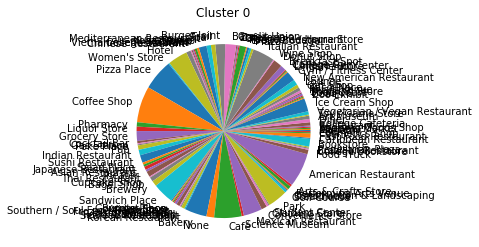

College  Tuition                       Coordinates  \
49  Brown University     25264  (41.82687235, -71.4012277069681)   

    Cluster Labels   Category 1 Category 2  Category 3  \
49               1  Coffee Shop       Café  Restaurant   

                 Category 4 Category 5   Category 6  Category 7  \
49  New American Restaurant        Bar  Pizza Place  Bagel Shop   

            Category 8        Category 9          Category 10  
49  Italian Restaurant  Asian Restaurant  American Restaurant

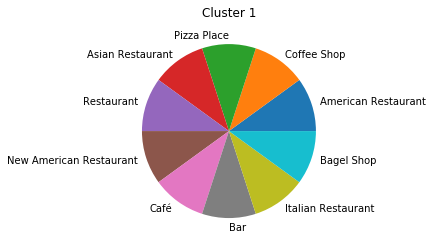

In [88]:
for i in range(len(sorted(clustered_df_specific['Cluster Labels'].unique()))):
    #print('Cluster {}'.format(i + 1))
    display(clustered_df_specific[clustered_df_specific['Cluster Labels'] == i])
    categories = clustered_df_specific[clustered_df_specific['Cluster Labels'] == i][['Category 1', 'Category 2', 'Category 3', 'Category 4', 'Category 5', 'Category 6', 'Category 7', 'Category 8', 'Category 9', 'Category 10']].values.flatten().tolist()
    vals = [categories.count(cat) for cat in set(categories)]
    plt.pie(vals, labels=list(set(categories)))
    plt.title('Cluster {}'.format(i))
    plt.show()

Interpreting the clusters above for specific venue categories is difficult and the results are inconclusive. It seems that clustering based on broad venue categories is more appropriate.